In [1]:
!pip install datasets
!pip install google-generativeai umap-learn scikit-learn pandas numpy tqdm python-dotenv
!pip install dotenv google-generativeai pydantic tqdm


In [2]:
import plotly.io as pio
pio.renderers.default = "iframe_connected"


In [3]:
# If needed, install:
# !pip install -U datasets pandas numpy networkx matplotlib scikit-learn pydantic python-dateutil tqdm
# Optional for cloud LLMs:
# !pip install -U openai groq google-generativeai

import os, json, random, math
from pathlib import Path
from datetime import datetime
from typing import Optional, List, Dict, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from pydantic import BaseModel, Field, ValidationError
from tqdm import tqdm
from datasets import load_dataset

from sklearn.feature_extraction.text import TfidfVectorizer


c:\Users\GP\AAU_BDS\Semester 01\Course02_Natural Language Processing\nlp.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [4]:
# !pip install datasets pandas pyarrow

from datasets import load_dataset
import pandas as pd
import random

# 1️⃣ Load dataset (cached locally after first run)
dataset = load_dataset("RJuro/eu_debates", split="train")

# 2️⃣ Convert to pandas
df = dataset.to_pandas()

# 3️⃣ Convert 'year' to string and filter speeches from 2023
df["year"] = df["year"].astype(str)
df_2023 = df[df["year"].str.contains("2023")].reset_index(drop=True)

print(f"✅ Found {len(df_2023)} speeches from 2023")

# 4️⃣ Random sample of 1000 speeches
df_2023_sample = df_2023.sample(n=min(500, len(df_2023)), random_state=42)

print(f"✅ Random sample of {len(df_2023_sample)} speeches ready!")
df_2023_sample.head(3)


✅ Found 10687 speeches from 2023
✅ Random sample of 500 speeches ready!


,speaker_name,speaker_role,speaker_party,intervention_language,original_language,date,year,debate_title,text,translated_text
3487,Claude Gruffat,MEP,Greens/EFA,fr,fr,2023-03-15,2023,Failure of the Silicon Valley Bank and the imp...,"– Madame la Présidente, la faillite de la Sil...","“Mr President, the bankruptcy of the Silicon ..."
668,Franc Bogovič,MEP,PPE,sl,sl,2023-01-18,2023,Conclusions of the European Council meeting of...,– Gospa predsednica. Razpravljamo o zelo pome...,Mrs President. We are discussing a very impor...
5999,Ladislav Ilčić,MEP,ECR,hr,hr,2023-05-09,2023,2022 Report on Serbia (debate),"– Poštovana predsjedavajuća, kolege, Srbija n...","“Honored President, colleagues, Serbia is not..."


In [5]:
df_2023_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 3487 to 7791
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   speaker_name           500 non-null    object        
 1   speaker_role           500 non-null    object        
 2   speaker_party          500 non-null    object        
 3   intervention_language  500 non-null    object        
 4   original_language      500 non-null    object        
 5   date                   500 non-null    datetime64[ms]
 6   year                   500 non-null    object        
 7   debate_title           500 non-null    object        
 8   text                   500 non-null    object        
 9   translated_text        340 non-null    object        
dtypes: datetime64[ms](1), object(9)
memory usage: 43.0+ KB


In [6]:
# Create a new column 'final_text':
# → if 'translated_text' is NOT null, use that
# → otherwise, fall back to 'text'
df_2023_sample["final_text"] = df_2023_sample.apply(
    lambda row: row["translated_text"] if pd.notnull(row["translated_text"]) and row["translated_text"].strip() != "" else row["text"],
    axis=1
)

# Optional: quick check
print(df_2023_sample[["text", "translated_text", "final_text"]].head(3))


                                                   text  \
3487   – Madame la Présidente, la faillite de la Sil...   
668    – Gospa predsednica. Razpravljamo o zelo pome...   
5999   – Poštovana predsjedavajuća, kolege, Srbija n...   

                                        translated_text  \
3487   “Mr President, the bankruptcy of the Silicon ...   
668    Mrs President. We are discussing a very impor...   
5999   “Honored President, colleagues, Serbia is not...   

                                             final_text  
3487   “Mr President, the bankruptcy of the Silicon ...  
668    Mrs President. We are discussing a very impor...  
5999   “Honored President, colleagues, Serbia is not...  


In [7]:
df_2023_sample.head()

,speaker_name,speaker_role,speaker_party,intervention_language,original_language,date,year,debate_title,text,translated_text,final_text
3487,Claude Gruffat,MEP,Greens/EFA,fr,fr,2023-03-15,2023,Failure of the Silicon Valley Bank and the imp...,"– Madame la Présidente, la faillite de la Sil...","“Mr President, the bankruptcy of the Silicon ...","“Mr President, the bankruptcy of the Silicon ..."
668,Franc Bogovič,MEP,PPE,sl,sl,2023-01-18,2023,Conclusions of the European Council meeting of...,– Gospa predsednica. Razpravljamo o zelo pome...,Mrs President. We are discussing a very impor...,Mrs President. We are discussing a very impor...
5999,Ladislav Ilčić,MEP,ECR,hr,hr,2023-05-09,2023,2022 Report on Serbia (debate),"– Poštovana predsjedavajuća, kolege, Srbija n...","“Honored President, colleagues, Serbia is not...","“Honored President, colleagues, Serbia is not..."
5331,Dita Charanzová,N/A,N/A,en,en,2023-04-19,2023,The crackdown on the right to education and ed...,The debate is closed and the vote will be held...,None,The debate is closed and the vote will be held...
1523,Manon Aubry,MEP,GUE/NGL,fr,fr,2023-02-13,2023,Order of business,au nom du groupe The Left. – Madame la Préside...,"The group is the Left. “Mr. President, dear co...","The group is the Left. “Mr. President, dear co..."


In [ ]:
import os, json, time, re
import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI

# ---------- 1) Environment & Client ----------
load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if not GEMINI_API_KEY:
    raise RuntimeError("Missing GEMINI_API_KEY in your .env")

client = OpenAI(
    api_key=GEMINI_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

GEMINI_MODEL = "gemini-2.5-flash"  # or "gemini-2.5-pro"

# ---------- 2) Prompt (strict JSON) ----------
# ---------- Prompt with ESCAPED braces ----------
PROMPT = """You are an information extractor. Return ONLY valid JSON.

Extract from the speech:
- topics: 1–3 SHORT topics (1–4 words, lowercase), e.g., "climate policy", "migration", "digital regulation".
- primary_topic: the single most central topic or null.

Schema:
{{
  "topics": ["string"],
  "primary_topic": "string|null"
}}

Rules:
- Output ONLY JSON. No prose.
- Topics must be generic noun phrases (1–4 words), lowercase.
- Avoid vague words like "policy" alone.

Speech:
\"\"\"{text}\"\"\""""


# ---------- 3) Robust JSON cleaners ----------
def _clean_json_text(raw: str) -> str:
    """Remove code fences and isolate outermost JSON object."""
    if not isinstance(raw, str):
        return "{}"
    # strip ```json ... ``` fences if present
    raw = re.sub(r"^```(?:json)?\s*|\s*```$", "", raw.strip(), flags=re.IGNORECASE)
    # keep only from first { to last }
    s, e = raw.find("{"), raw.rfind("}")
    if s != -1 and e != -1 and s < e:
        raw = raw[s:e+1]
    return raw.strip() or "{}"

# ---------- 4) Gemini call with retries & normalization ----------
def call_gemini_json(text: str, retries: int = 3, backoff: float = 0.6):
    prompt = PROMPT.format(text=(text or "")[:7000])  # safety truncation
    last_raw = ""
    for attempt in range(retries):
        try:
            resp = client.chat.completions.create(
                model=GEMINI_MODEL,
                temperature=0,
                # JSON mode (if supported by the OpenAI-compatible endpoint)
                response_format={"type": "json_object"},
                messages=[{"role":"user","content": prompt}],
            )
            raw = resp.choices[0].message.content or ""
            last_raw = raw
            raw = _clean_json_text(raw)
            data = json.loads(raw)

            # Be defensive if an array comes back
            if isinstance(data, list) and data and isinstance(data[0], dict):
                data = data[0]

            topics = data.get("topics") or []
            topics = [t.strip().lower() for t in topics if isinstance(t, str) and t.strip()]

            # dedupe + cap at 3
            clean = []
            seen = set()
            for t in topics:
                if t not in seen:
                    seen.add(t)
                    clean.append(t)
                if len(clean) == 3:
                    break

            primary = (data.get("primary_topic") or "").strip().lower() or None
            if primary and primary not in clean:
                clean = [primary] + clean
                clean = clean[:3]

            return {"topics": clean, "primary_topic": primary, "_ok": True}
        except Exception:
            time.sleep(backoff * (attempt + 1))
    return {"topics": [], "primary_topic": None, "_ok": False, "_raw": last_raw}

# ---------- 5) Run over your df_2023_sample ----------
# Expect columns: final_text, speaker_name, date, intervention_language
assert "df_2023_sample" in globals(), "Please load df_2023_sample first."
assert "final_text" in df_2023_sample.columns, "df_2023_sample must have a 'final_text' column."

df = df_2023_sample[["final_text","speaker_name","date","intervention_language"]].dropna(subset=["final_text"]).reset_index(drop=True)

doc_rows, triple_rows = [], []
for i, r in tqdm(df.iterrows(), total=len(df), desc="Extracting topics from speeches"):
    ext = call_gemini_json(r["final_text"])
    topics = ext["topics"]
    primary = ext["primary_topic"]

    # build per-speech record
    doc_rows.append({
        "doc_id": i,
        "speaker": r.get("speaker_name"),
        "date": r.get("date"),
        "language": r.get("intervention_language"),
        "topics": topics,
        "primary_topic": primary,
        "ok": ext.get("_ok", False),
    })

    # build triple(s)
    for t in topics:
        triple_rows.append({
            "doc_id": i,
            "subject": r.get("speaker_name"),
            "relation": "Mentions_Topic",
            "object": t,
        })

docs_df = pd.DataFrame(doc_rows)
triples_df = pd.DataFrame(triple_rows)

# Optional: save artifacts for later steps
docs_df.to_parquet("docs_topics.parquet")
triples_df.to_parquet("triples_topics.parquet")

print("Docs:", docs_df.shape, "| Triples:", triples_df.shape)
print(docs_df.head(3)[["speaker","primary_topic","topics"]])
print(triples_df.head(5))

In [8]:
docs_df = pd.read_parquet("docs_topics.parquet")
triples_df = pd.read_parquet("triples_topics.parquet")

In [9]:
docs_df.head()

,doc_id,speaker,date,language,topics,primary_topic,ok
0,0,Claude Gruffat,2023-03-15,fr,"[banking crisis, financial deregulation, banki...",banking regulation,True
1,1,Franc Bogovič,2023-01-18,sl,"[nuclear energy, energy transition, european e...",nuclear energy,True
2,2,Ladislav Ilčić,2023-05-09,hr,"[serbia-russia relations, serbian nationalism,...",serbia-russia relations,True
3,3,Dita Charanzová,2023-04-19,en,[],None,True
4,4,Manon Aubry,2023-02-13,fr,"[parliamentary corruption, institutional trans...",parliamentary corruption,True


In [118]:
import pandas as pd

# ----------------------------------------------------
# 1. Load extracted topics (LLM output)
#    This file comes from your Gemini extraction step
# ----------------------------------------------------
docs_df = pd.read_parquet("docs_topics.parquet")
docs_df = docs_df.reset_index(drop=True)

print("docs_topics.parquet loaded:", docs_df.shape)
print(docs_df.head(2))

# Expected columns in docs_df:
# ['doc_id', 'speaker', 'date', 'language', 'topics', 'primary_topic', 'ok']

# ----------------------------------------------------
# 2. Load your base dataset (df_2023_sample should already be in memory)
# ----------------------------------------------------
if "df_2023_sample" not in globals():
    raise RuntimeError("df_2023_sample is not defined. Please load it before running this cell.")

# Try to detect which columns contain the original and translated texts
possible_original_cols = ["final_text", "text", "speech", "raw_text"]
possible_trans_cols    = ["translated_text", "translation", "translated", "en_text"]

orig_col = next((c for c in possible_original_cols if c in df_2023_sample.columns), None)
trans_col = next((c for c in possible_trans_cols if c in df_2023_sample.columns), None)

if orig_col is None:
    raise ValueError(f"No valid ORIGINAL text column found in df_2023_sample. "
                     f"Looked for: {possible_original_cols}. Available: {list(df_2023_sample.columns)}")

if trans_col is None:
    print("No translated column found. Using original only.")
else:
    print(f"Using translated column: {trans_col}")

# Build base dataframe with only the columns that actually exist
base_cols = ["speaker_name", "date", "intervention_language"]
base_cols = [c for c in base_cols if c in df_2023_sample.columns]

use_cols = [orig_col] + base_cols + ([trans_col] if trans_col else [])
df_base = df_2023_sample[use_cols].copy()

# Drop rows where original text is missing
df_base = df_base.dropna(subset=[orig_col]).reset_index(drop=True)

# ----------------------------------------------------
# 3. Ensure doc_id matches between both dataframes
#    We recreate doc_id in the same way you did for extraction:
#    df_2023_sample.reset_index() → index used as doc_id
# ----------------------------------------------------
df_base = df_base.reset_index().rename(columns={"index": "doc_id"})

# IMPORTANT: do NOT overwrite docs_df['doc_id'], it comes from extraction
docs_df = docs_df.copy()

# ----------------------------------------------------
# 4. Merge LLM topics with base texts on doc_id
# ----------------------------------------------------
merged_df = pd.merge(df_base, docs_df, on="doc_id", how="inner")
print("Merged dataset:", merged_df.shape)

# ----------------------------------------------------
# 5. Pick up to 15 random examples
# ----------------------------------------------------
n_examples = min(15, len(merged_df))
sample_df = merged_df.sample(n_examples, random_state=42)

# ----------------------------------------------------
# 6. Pretty-print results for manual evaluation
# ----------------------------------------------------
pd.set_option("display.max_colwidth", 1000)

example_counter = 1
for idx, row in sample_df.iterrows():
    print("=" * 100)
    print(f"Example {example_counter}/{n_examples}")
    print(f"Doc ID: {row['doc_id']}")
    print(f"Speaker: {row.get('speaker_name', 'Unknown')}")
    print(f"Date: {row.get('date', 'Unknown')}")
    print(f"Language: {row.get('intervention_language', 'Unknown')}")
    print(f"Primary Topic (LLM): {row.get('primary_topic')}")
    print(f"All Topics (LLM): {row.get('topics')}")
    print("-" * 100)

    # Original speech (from the column we detected)
    print("\nORIGINAL SPEECH:\n")
    original_text = str(row[orig_col])
    print(original_text[:1500] + ("...\n" if len(original_text) > 1500 else "\n"))

    # Translated speech (if a translated column exists and is not null)
    if trans_col and pd.notnull(row.get(trans_col)):
        print("ENGLISH TRANSLATION (from dataset):\n")
        translated_text = str(row[trans_col])
        print(translated_text[:1500] + ("...\n" if len(translated_text) > 1500 else "\n"))
    else:
        print("No translated version found in dataset.\n")

    print("=" * 100 + "\n")
    example_counter += 1

docs_topics.parquet loaded: (500, 7)
   doc_id         speaker       date language  \
0       0  Claude Gruffat 2023-03-15       fr   
1       1   Franc Bogovič 2023-01-18       sl   

                                              topics       primary_topic    ok  
0  [banking crisis, financial deregulation, banki...  banking regulation  True  
1  [nuclear energy, energy transition, european e...      nuclear energy  True  
Using translated column: translated_text
Merged dataset: (500, 12)
Example 1/15
Doc ID: 361
Speaker: Edina Tóth
Date: Unknown
Language: hu
Primary Topic (LLM): None
All Topics (LLM): []
----------------------------------------------------------------------------------------------------

ORIGINAL SPEECH:

in writing. The amount of waste generated in most European countries and in the EU is increasing and the Member States are exporting more and more waste. Nearly half of this is in countries where waste is not treated in an environmentally friendly way, thereby incre

we found a few wrong labelling and also in many cases it did not label at all where topics were pretty clear in the speeches.
We will now look into the situation where we might find empty strings in the data

In [ ]:
#find all cases where primary topic and topics is empty or null 
docs_df[(docs_df["primary_topic"].isnull()) | (docs_df["primary_topic"] == "") & (docs_df["topics"].apply(lambda x: len(x) == 0)) ]

#printing the count
print(docs_df[(docs_df["primary_topic"].isnull()) | (docs_df["primary_topic"] == "") & (docs_df["topics"].apply(lambda x: len(x) == 0)) ])

     doc_id                        speaker       date language topics  \
3         3                Dita Charanzová 2023-04-19       en     []   
18       18                 Karen Melchior 2023-01-18       en     []   
43       43                   Nora Mebarek 2023-04-20       fr     []   
49       49                  Laura Ferrara 2023-04-18       it     []   
50       50  Alexander Alexandrov Yordanov 2023-04-19       bg     []   
..      ...                            ...        ...      ...    ...   
495     495                Fabienne Keller 2023-07-12       fr     []   
496     496                 Mazaly Aguilar 2023-07-11       es     []   
497     497                 Loucas Fourlas 2023-09-12       el     []   
498     498                 Hannah Neumann 2023-09-11       en     []   
499     499                Jessika Roswall 2023-06-14       en     []   

    primary_topic     ok  n_topics  topic_cluster_id topic_cluster_label  
3            None   True         0              

In [44]:
#drop rows where primary topic is null or empty
docs_df = docs_df[docs_df["primary_topic"].notnull() & (docs_df["primary_topic"] != "")].copy()

In [45]:
docs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, 0 to 234
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   doc_id         145 non-null    int64         
 1   speaker        145 non-null    object        
 2   date           145 non-null    datetime64[ns]
 3   language       145 non-null    object        
 4   topics         145 non-null    object        
 5   primary_topic  145 non-null    object        
 6   ok             145 non-null    bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(4)
memory usage: 8.1+ KB


In [46]:
triples_df.head()

,doc_id,subject,relation,object
0,0,Claude Gruffat,Mentions_Topic,banking crisis
1,0,Claude Gruffat,Mentions_Topic,financial deregulation
2,0,Claude Gruffat,Mentions_Topic,banking regulation
3,1,Franc Bogovič,Mentions_Topic,nuclear energy
4,1,Franc Bogovič,Mentions_Topic,energy transition


Basic stats overview

In [54]:
# success ratio of the extraction
print("Valid extractions (%):", docs_df["ok"].mean() * 100)

# how many topics per speech
docs_df["n_topics"] = docs_df["topics"].apply(len)
print("Average topics per speech:", docs_df["n_topics"].mean())

# speakers with most speeches
print("\nTop 10 speakers:\n", docs_df["speaker"].value_counts().head(10))

# most frequent primary topics
print("\nTop 10 topics:\n", docs_df["primary_topic"].value_counts().head(10))


Valid extractions (%): 100.0
Average topics per speech: 2.924137931034483

Top 10 speakers:
 speaker
Ladislav Ilčić          4
Othmar Karas            3
Roberta Metsola         3
Manon Aubry             2
Janusz Wojciechowski    2
Balázs Hidvéghi         2
Clare Daly              2
Angel Dzhambazki        2
Isabel Santos           2
Michiel Hoogeveen       2
Name: count, dtype: int64

Top 10 topics:
 primary_topic
rule of law                  4
banking regulation           2
migration policy             2
migration                    2
cryptocurrency regulation    2
parliamentary integrity      2
parliamentary procedure      2
minority rights              2
food security                2
istanbul convention          2
Name: count, dtype: int64


visual exploration    most disccussed topic

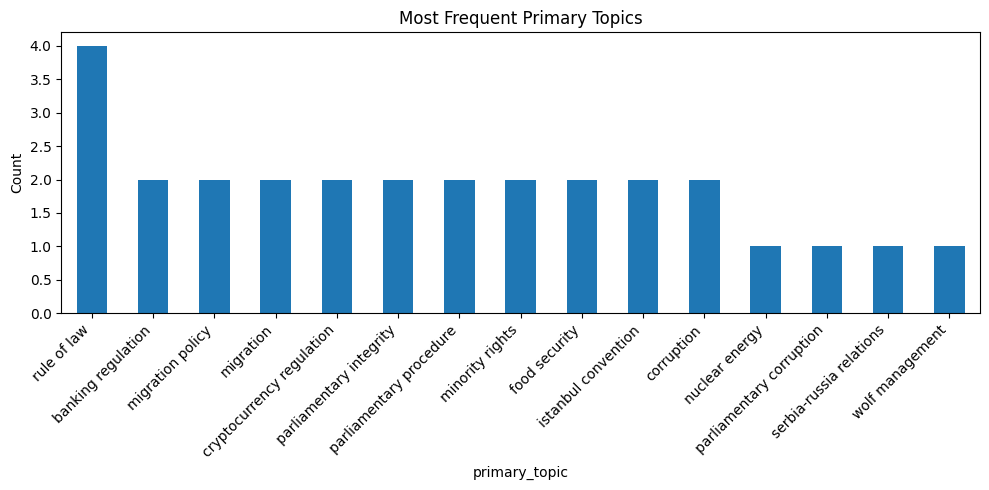

In [55]:
plt.figure(figsize=(10,5))
docs_df["primary_topic"].value_counts().head(15).plot(kind="bar")
plt.title("Most Frequent Primary Topics")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


most active speakers

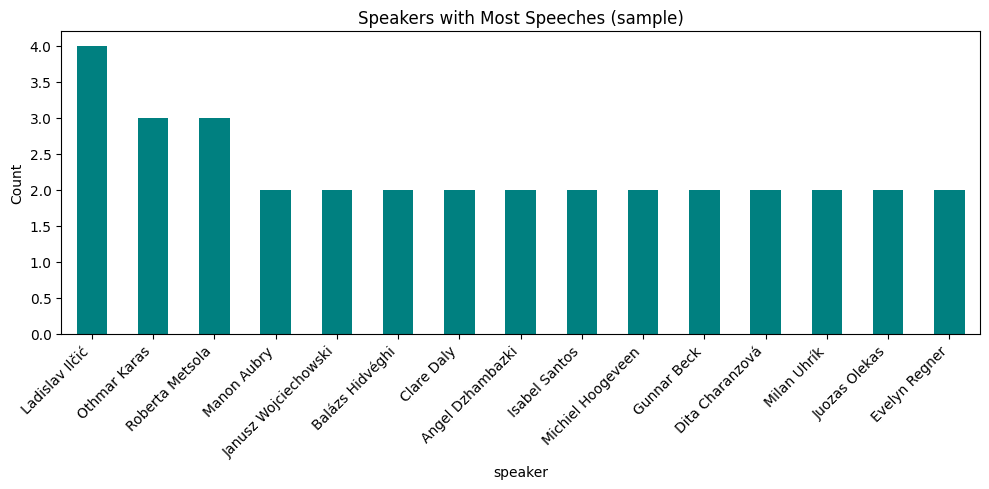

In [56]:
plt.figure(figsize=(10,5))
docs_df["speaker"].value_counts().head(15).plot(kind="bar", color="teal")
plt.title("Speakers with Most Speeches (sample)")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


#### Now we try to cluster the primary topics into more reasonable similar groups to have better analysis and insights

In [ ]:
# pip install google-generativeai python-dotenv pandas

import os
import json
import textwrap
import re
import pandas as pd
from dotenv import load_dotenv
import google.generativeai as genai

# 1) Setup Gemini (use a widely supported model)
load_dotenv()
API_KEY = os.getenv("GEMINI_API_KEY")
if not API_KEY:
    raise RuntimeError("Missing GEMINI_API_KEY in .env")

genai.configure(api_key=API_KEY)
model = genai.GenerativeModel("gemini-2.5-flash")   # <-- gemini-pro works reliably

# 2) Extract unique primary topics from docs_df
if "docs_df" not in globals():
    raise RuntimeError("docs_df is not available in the environment")

topics_series = (
    docs_df["primary_topic"]
    .astype(str)
    .str.strip()
    .str.lower()
)
topics_series = topics_series[topics_series != ""]
unique_topics = sorted(topics_series.unique().tolist())

print(f"Loaded {len(unique_topics)} unique topics from docs_df.")

# 3) Build prompt for Gemini to decide the clusters
topics_block = "\n".join(f"- {t}" for t in unique_topics)

prompt = textwrap.dedent(f"""
    You are an expert in European Union politics and policy.

    I will give you a list of short 'primary topic' labels extracted from EU parliamentary speeches.
    Your task is to cluster these topics into a SMALL number of coherent high-level groups.

    Requirements:
    - YOU choose the number of clusters (usually between 5 and 15).
    - Each topic must belong to exactly ONE cluster.
    - Clusters must be semantically meaningful.
    - For each cluster, output:
        - an integer id
        - a short label (2–5 words)
        - a one-sentence description
        - the list of member topics (exactly matching the input strings)

    Input topics:
    {topics_block}

    Output ONLY JSON in this format:

    {{
      "clusters": [
        {{
          "id": 0,
          "label": "short label",
          "description": "one sentence",
          "members": ["topic A", "topic B", "..."]
        }},
        {{
          "id": 1,
          "label": "...",
          "description": "...",
          "members": ["..."]
        }}
      ]
    }}
""").strip()


def extract_json_block(raw: str) -> str:
    """Extract JSON from Gemini output in case it adds markdown fences."""
    if not isinstance(raw, str):
        return "{}"
    raw = raw.strip()
    raw = re.sub(r"^```(?:json)?\s*|\s*```$", "", raw, flags=re.IGNORECASE)
    s, e = raw.find("{"), raw.rfind("}")
    if s != -1 and e != -1:
        return raw[s:e+1]
    return raw


# 4) Call Gemini
resp = model.generate_content(prompt)
raw = resp.text or ""
json_str = extract_json_block(raw)

# 5) Parse JSON
data = json.loads(json_str)
clusters = data.get("clusters", [])

print(f"\nGemini created {len(clusters)} clusters.")
for c in clusters:
    print(f"Cluster {c.get('id')}: {c.get('label')}  (members: {len(c.get('members',[]))})")

# 6) Build topic → cluster mapping
rows = []
for c in clusters:
    cid = c["id"]
    lab = c["label"]
    desc = c["description"]
    for t in c["members"]:
        rows.append({
            "topic": t,
            "cluster_id": cid,
            "cluster_label": lab,
            "cluster_description": desc
        })

clusters_df = pd.DataFrame(rows)

# 7) Attach back to docs_df
mapping = clusters_df.set_index("topic")

def lookup_cluster(topic):
    t = str(topic).strip().lower()
    if t in mapping.index:
        return pd.Series([
            mapping.loc[t]["cluster_id"],
            mapping.loc[t]["cluster_label"],
            mapping.loc[t]["cluster_description"]
        ])
    return pd.Series([None, None, None])

docs_df[["topic_cluster_id",
         "topic_cluster_label",
         "topic_cluster_description"]] = docs_df["primary_topic"].apply(lookup_cluster)

print("\nSample with clusters applied to docs_df:")
print(
    docs_df[["primary_topic", "topic_cluster_id", "topic_cluster_label"]]
    .dropna()
    .head(15)
)

# 8) Save mapping
clusters_df.to_csv("gemini_topic_clusters.csv", index=False)
print("\nSaved cluster mapping to gemini_topic_clusters.csv")


Loaded 132 unique topics from docs_df.

Gemini created 9 clusters.
Cluster 0: EU Governance & Rule of Law  (members: 28)
Cluster 1: Economy, Finance & Competitiveness  (members: 20)
Cluster 2: Climate, Energy & Environment  (members: 15)
Cluster 3: Social Rights & Equality within the EU  (members: 12)
Cluster 4: Global Human Rights & Democracy  (members: 15)
Cluster 5: Migration & Asylum Policy  (members: 7)
Cluster 6: Foreign Policy, Defence & Geopolitics  (members: 17)
Cluster 7: Health & Crisis Preparedness  (members: 6)
Cluster 8: Digital, Industry & Agriculture  (members: 11)

Sample with clusters applied to docs_df:
                     primary_topic  topic_cluster_id  \
0               banking regulation               1.0   
1                   nuclear energy               2.0   
2          serbia-russia relations               6.0   
4         parliamentary corruption               0.0   
5       maritime search and rescue               5.0   
6                        inflation

In [64]:
docs_df.head()


,doc_id,speaker,date,language,topics,primary_topic,ok,n_topics,topic_cluster_id,topic_cluster_label,topic_cluster_description
0,0,Claude Gruffat,2023-03-15,fr,"[banking crisis, financial deregulation, banki...",banking regulation,True,3,1.0,"Economy, Finance & Competitiveness","Addresses economic policy, financial market st..."
1,1,Franc Bogovič,2023-01-18,sl,"[nuclear energy, energy transition, european e...",nuclear energy,True,3,2.0,"Climate, Energy & Environment","Covers policies related to climate action, ren..."
2,2,Ladislav Ilčić,2023-05-09,hr,"[serbia-russia relations, serbian nationalism,...",serbia-russia relations,True,3,6.0,"Foreign Policy, Defence & Geopolitics","Deals with the EU's external relations, strate..."
4,4,Manon Aubry,2023-02-13,fr,"[parliamentary corruption, institutional trans...",parliamentary corruption,True,3,0.0,EU Governance & Rule of Law,Focuses on the internal functioning of EU inst...
5,5,Isabel García Muñoz,2023-07-12,es,"[maritime search and rescue, saving lives at s...",maritime search and rescue,True,3,5.0,Migration & Asylum Policy,"Encompasses the management of migration flows,..."


### Now we start to build the networks

## Building a network Speakers -> topic cluster

In [72]:
import pandas as pd
import networkx as nx

# 1) Start from docs_df: keep only rows with a cluster label
df_sc = docs_df[["speaker", "topic_cluster_label"]].copy()
df_sc["speaker"] = df_sc["speaker"].astype(str).str.strip()
df_sc["topic_cluster_label"] = df_sc["topic_cluster_label"].astype(str).str.strip()

df_sc = df_sc[
    (df_sc["speaker"] != "") &
    (df_sc["topic_cluster_label"] != "") &
    (~df_sc["topic_cluster_label"].isna())
].reset_index(drop=True)

# 2) Count how many speeches per (speaker, cluster)
edge_counts_sc = (
    df_sc
    .groupby(["speaker", "topic_cluster_label"])
    .size()
    .reset_index(name="weight")
)

edge_counts_sc.head()


,speaker,topic_cluster_label,weight
0,Achille Variati,"Digital, Industry & Agriculture",1
1,Adam Jarubas,Social Rights & Equality within the EU,1
2,Alexander Bernhuber,"Climate, Energy & Environment",1
3,Alexandr Vondra,"Climate, Energy & Environment",1
4,Alfred Sant,"Economy, Finance & Competitiveness",1


In [73]:
G_SC = nx.Graph()

# Add node types
speakers = edge_counts_sc["speaker"].unique()
clusters = edge_counts_sc["topic_cluster_label"].unique()

G_SC.add_nodes_from(speakers, node_type="speaker")
G_SC.add_nodes_from(clusters, node_type="topic_cluster")

# Add weighted edges
for _, row in edge_counts_sc.iterrows():
    G_SC.add_edge(
        row["speaker"],
        row["topic_cluster_label"],
        relation="talks_about",
        weight=row["weight"]
    )

print("Nodes:", G_SC.number_of_nodes(), "Edges:", G_SC.number_of_edges())


Nodes: 135 Edges: 139


Speakers: 125, Clusters: 10


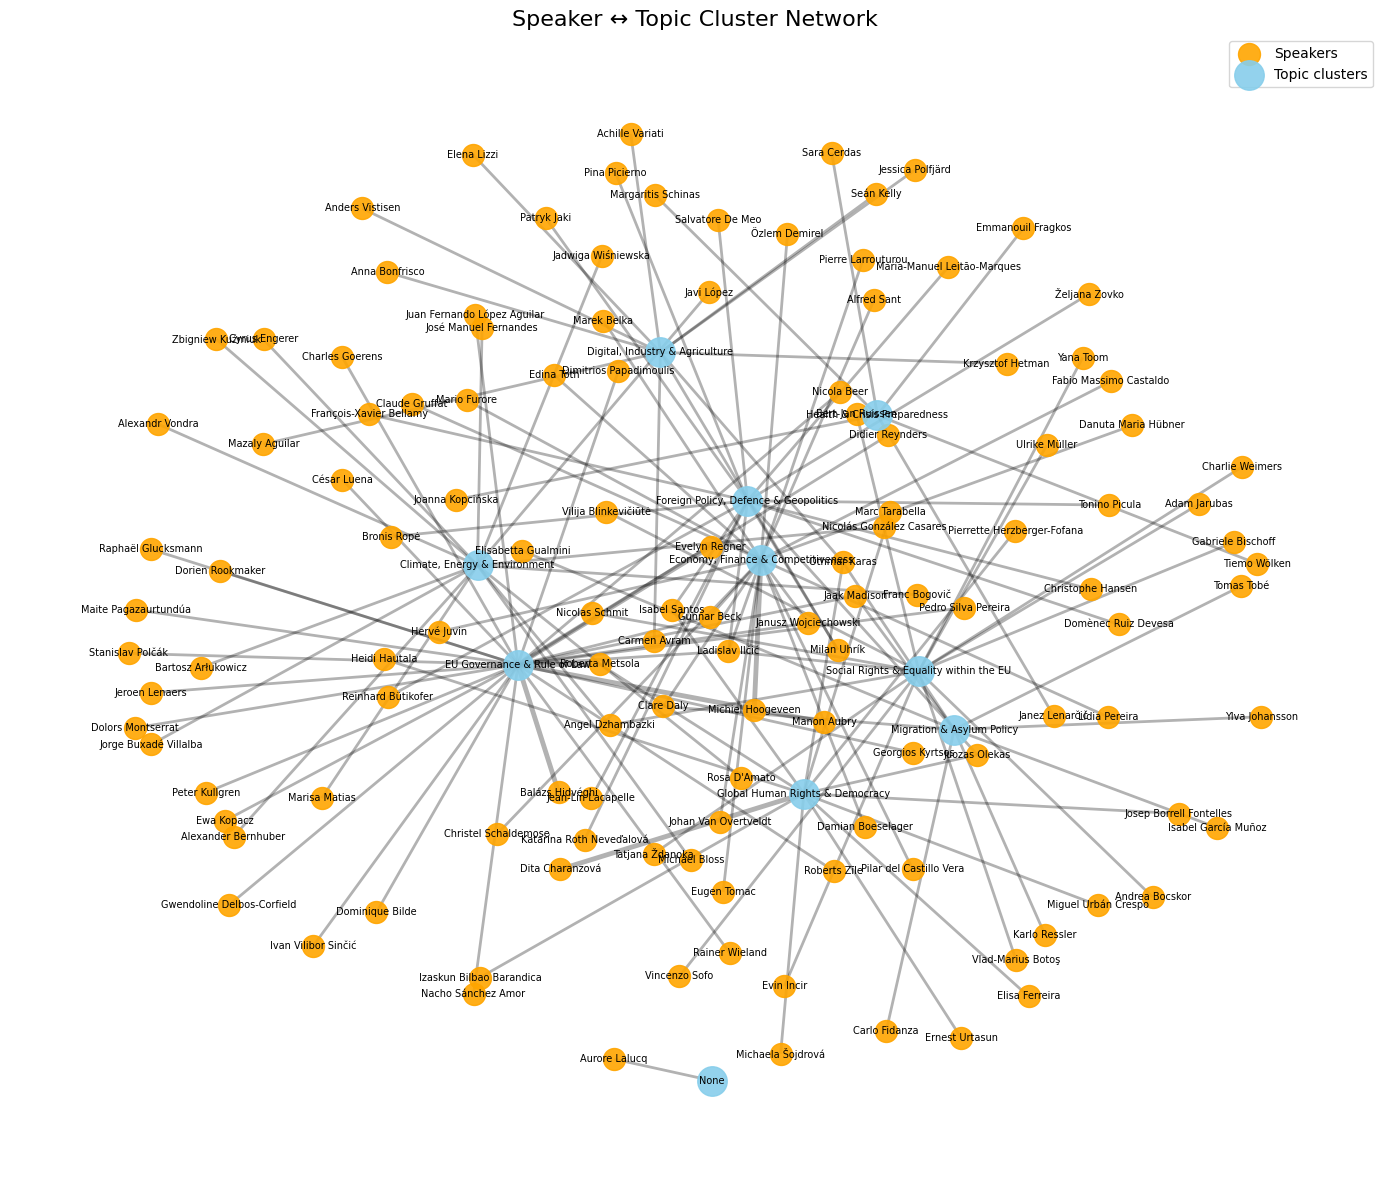

In [74]:
import matplotlib.pyplot as plt

# Separate node sets
speaker_nodes = [n for n, d in G_SC.nodes(data=True) if d["node_type"] == "speaker"]
cluster_nodes = [n for n, d in G_SC.nodes(data=True) if d["node_type"] == "topic_cluster"]

print(f"Speakers: {len(speaker_nodes)}, Clusters: {len(cluster_nodes)}")

# Layout
pos_sc = nx.spring_layout(G_SC, k=0.9, iterations=100, seed=42)

# Edge widths based on weight (how many speeches)
weights = [G_SC[u][v].get("weight", 1) for u, v in G_SC.edges()]
max_w = max(weights) if weights else 1
edge_widths = [0.5 + 3 * (w / max_w) for w in weights]

plt.figure(figsize=(14, 12))

# Draw edges
nx.draw_networkx_edges(G_SC, pos_sc, width=edge_widths, alpha=0.3)

# Draw nodes
nx.draw_networkx_nodes(
    G_SC, pos_sc,
    nodelist=speaker_nodes,
    node_color="orange",
    node_size=250,
    alpha=0.9,
    label="Speakers"
)

nx.draw_networkx_nodes(
    G_SC, pos_sc,
    nodelist=cluster_nodes,
    node_color="skyblue",
    node_size=450,
    alpha=0.9,
    label="Topic clusters"
)

# Labels: speakers + cluster labels
labels_sc = {}
for n in speaker_nodes:
    labels_sc[n] = n
for n in cluster_nodes:
    labels_sc[n] = n

nx.draw_networkx_labels(G_SC, pos_sc, labels=labels_sc, font_size=7)

plt.title("Speaker ↔ Topic Cluster Network", fontsize=16)
plt.axis("off")
plt.legend(scatterpoints=1)
plt.tight_layout()
plt.show()


In [105]:
import networkx as nx
import pandas as pd

# Use the speaker–cluster graph
G = G_SC   # <-- change if your graph variable has a different name

# ============================
# 1) DEGREE CENTRALITY
# ============================
deg_cent = nx.degree_centrality(G)

deg_df = pd.DataFrame([
    {
        "node": n,
        "node_type": G.nodes[n].get("node_type"),
        "degree_centrality": deg_cent[n]
    }
    for n in G.nodes()
]).sort_values("degree_centrality", ascending=False)


# ============================
# 2) WEIGHTED DEGREE (strength)
# ============================
weighted_degree = dict(G.degree(weight="weight"))

wdeg_df = pd.DataFrame([
    {
        "node": n,
        "node_type": G.nodes[n].get("node_type"),
        "weighted_degree": weighted_degree[n]
    }
    for n in G.nodes()
]).sort_values("weighted_degree", ascending=False)


# ============================
# 3) BETWEENNESS CENTRALITY
# ============================
bet_cent = nx.betweenness_centrality(G, normalized=True)

bet_df = pd.DataFrame([
    {
        "node": n,
        "node_type": G.nodes[n].get("node_type"),
        "betweenness": bet_cent[n]
    }
    for n in G.nodes()
]).sort_values("betweenness", ascending=False)


# ============================
# 4) CLOSENESS CENTRALITY (optional)
# ============================
clo_cent = nx.closeness_centrality(G)

clo_df = pd.DataFrame([
    {
        "node": n,
        "node_type": G.nodes[n].get("node_type"),
        "closeness": clo_cent[n]
    }
    for n in G.nodes()
]).sort_values("closeness", ascending=False)


# ============================
# 5) Show top results
# ============================
print("\n=== TOP SPEAKERS BY DEGREE CENTRALITY ===")
print(deg_df[deg_df["node_type"]=="speaker"].head(10))

print("\n=== TOP TOPIC CLUSTERS BY DEGREE CENTRALITY ===")
print(deg_df[deg_df["node_type"]=="topic_cluster"].head(10))


print("\n=== TOP SPEAKERS BY WEIGHTED DEGREE (Strength) ===")
print(wdeg_df[wdeg_df["node_type"]=="speaker"].head(10))

print("\n=== TOP CLUSTERS BY WEIGHTED DEGREE (Strength) ===")
print(wdeg_df[wdeg_df["node_type"]=="topic_cluster"].head(10))


print("\n=== TOP SPEAKERS BY BETWEENNESS CENTRALITY ===")
print(bet_df[bet_df["node_type"]=="speaker"].head(10))

print("\n=== TOP CLUSTERS BY BETWEENNESS CENTRALITY ===")
print(bet_df[bet_df["node_type"]=="topic_cluster"].head(10))


print("\n=== TOP SPEAKERS BY CLOSENESS CENTRALITY ===")
print(clo_df[clo_df["node_type"]=="speaker"].head(10))

print("\n=== TOP CLUSTERS BY CLOSENESS CENTRALITY ===")
print(clo_df[clo_df["node_type"]=="topic_cluster"].head(10))



=== TOP SPEAKERS BY DEGREE CENTRALITY ===
                     node node_type  degree_centrality
74         Ladislav Ilčić   speaker           0.029851
94           Othmar Karas   speaker           0.022388
56           Jaak Madison   speaker           0.014925
20             Clare Daly   speaker           0.014925
48            Gunnar Beck   speaker           0.014925
105       Roberta Metsola   speaker           0.014925
89            Milan Uhrík   speaker           0.014925
59   Janusz Wojciechowski   speaker           0.014925
53          Isabel Santos   speaker           0.014925
7        Angel Dzhambazki   speaker           0.014925

=== TOP TOPIC CLUSTERS BY DEGREE CENTRALITY ===
                                       node      node_type  degree_centrality
130             EU Governance & Rule of Law  topic_cluster           0.223881
128      Economy, Finance & Competitiveness  topic_cluster           0.156716
131   Foreign Policy, Defence & Geopolitics  topic_cluster           

### Centrality Analysis Summary
Centrality analysis reveals clear structural patterns in the speaker–topic cluster network.
Degree and weighted degree show that Ladislav Ilčić, Othmar Karas and Roberta Metsola are the most active and broadly connected speakers, engaging across multiple thematic clusters.
Among topics, EU Governance & Rule of Law, Economy, Foreign Policy, and Social Rights emerge as the most widely discussed clusters.

Betweenness centrality identifies Ilčić and Angel Dzhambazki as key bridges in the debate space, connecting otherwise separate thematic clusters.
On the thematic side, Governance, Social Rights, and Foreign Policy act as major structural “hinge” topics linking various issue arenas.

Finally, closeness centrality highlights Ilčić, Metsola and Madison as globally central speakers with efficient reach across the network. Thematically, Governance, Foreign Policy, Social Rights and Economy are closest to all other clusters, underlining their centrality in European Parliamentary discourse.

Together, these measures show that a small set of MEPs and core issue clusters dominate and structure the 2023 EP debate network.


## Building a network graph showing connection Party-> Topic

In [86]:
# Make a slim lookup table: speaker_name → speaker_party
party_lookup = (
    df_2023_sample[["speaker_name", "speaker_party"]]
    .drop_duplicates()
)

# Merge into docs_df (match docs_df.speaker to df_2023_sample.speaker_name)
docs_df = docs_df.merge(
    party_lookup,
    left_on="speaker",
    right_on="speaker_name",
    how="left"
)

# Clean up: keep a single speaker column + speaker_party
docs_df.drop(columns=["speaker_name"], inplace=True)

# Optional: strip whitespace
docs_df["speaker_party"] = docs_df["speaker_party"].astype(str).str.strip()

print(docs_df[["speaker", "speaker_party", "topic_cluster_label"]].head())


               speaker speaker_party                    topic_cluster_label
0       Claude Gruffat    Greens/EFA     Economy, Finance & Competitiveness
1        Franc Bogovič           PPE          Climate, Energy & Environment
2       Ladislav Ilčić           ECR  Foreign Policy, Defence & Geopolitics
3          Manon Aubry       GUE/NGL            EU Governance & Rule of Law
4  Isabel García Muñoz           S&D              Migration & Asylum Policy


In [87]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1) Extract relevant columns
df_pc = docs_df[["speaker_party", "topic_cluster_label"]].copy()

df_pc["speaker_party"] = df_pc["speaker_party"].astype(str).str.strip()
df_pc["topic_cluster_label"] = df_pc["topic_cluster_label"].astype(str).str.strip()

# Remove missing values
df_pc = df_pc[
    (df_pc["speaker_party"] != "") &
    (df_pc["speaker_party"].notna()) &
    (df_pc["topic_cluster_label"] != "") &
    (df_pc["topic_cluster_label"].notna())
].reset_index(drop=True)

# 2) Count speeches per (party, cluster)
edge_counts_pc = (
    df_pc
    .groupby(["speaker_party", "topic_cluster_label"])
    .size()
    .reset_index(name="weight")
)

edge_counts_pc.head()


,speaker_party,topic_cluster_label,weight
0,ALDE,EU Governance & Rule of Law,4
1,ALDE,Global Human Rights & Democracy,1
2,ALDE,Social Rights & Equality within the EU,3
3,ECR,"Climate, Energy & Environment",4
4,ECR,"Digital, Industry & Agriculture",1


In [88]:
# Create graph
G_PC = nx.Graph()

parties = edge_counts_pc["speaker_party"].unique()
clusters = edge_counts_pc["topic_cluster_label"].unique()

G_PC.add_nodes_from(parties,  node_type="party")
G_PC.add_nodes_from(clusters, node_type="topic_cluster")

# Add weighted edges
for _, row in edge_counts_pc.iterrows():
    G_PC.add_edge(
        row["speaker_party"],
        row["topic_cluster_label"],
        weight=row["weight"],
        relation="party_discusses_cluster"
    )

print("Nodes:", G_PC.number_of_nodes(), "Edges:", G_PC.number_of_edges())


Nodes: 19 Edges: 59


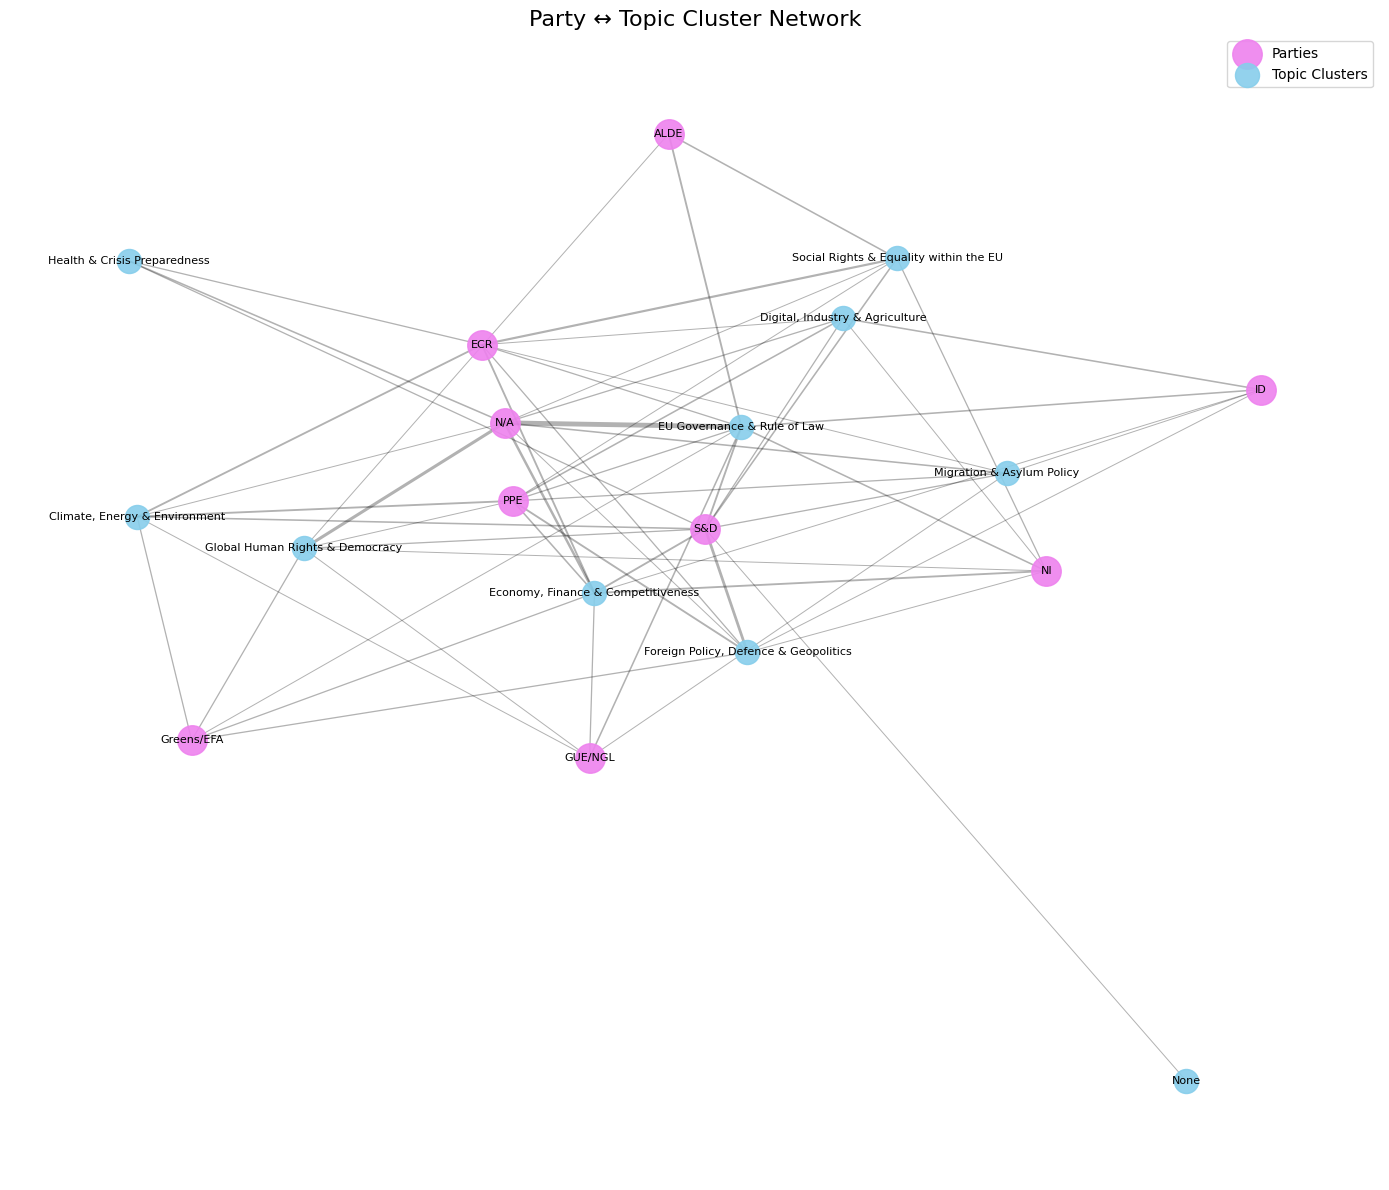

In [89]:
# Separate node sets
party_nodes   = [n for n, d in G_PC.nodes(data=True) if d["node_type"] == "party"]
cluster_nodes = [n for n, d in G_PC.nodes(data=True) if d["node_type"] == "topic_cluster"]

# Layout
pos = nx.spring_layout(G_PC, k=0.8, iterations=100, seed=42)

# Edge widths = number of speeches
weights = [G_PC[u][v]["weight"] for u, v in G_PC.edges()]
max_w = max(weights) if weights else 1
edge_widths = [0.5 + 3 * (w / max_w) for w in weights]

plt.figure(figsize=(14, 12))

# Draw edges
nx.draw_networkx_edges(G_PC, pos, width=edge_widths, alpha=0.3)

# Draw party nodes
nx.draw_networkx_nodes(
    G_PC, pos,
    nodelist=party_nodes,
    node_color="violet",
    node_size=450,
    alpha=0.9,
    label="Parties"
)

# Draw topic cluster nodes
nx.draw_networkx_nodes(
    G_PC, pos,
    nodelist=cluster_nodes,
    node_color="skyblue",
    node_size=300,
    alpha=0.9,
    label="Topic Clusters"
)

# Labels (both parties + clusters)
labels = {n: n for n in G_PC.nodes()}
nx.draw_networkx_labels(G_PC, pos, labels=labels, font_size=8)

plt.title("Party ↔ Topic Cluster Network", fontsize=16)
plt.axis("off")
plt.legend(scatterpoints=1)
plt.tight_layout()
plt.show()


In [106]:
import networkx as nx
import pandas as pd

# Use your Party–Cluster graph
G = G_PC   # <-- make sure this is the correct variable name

# ============================
# 1) DEGREE CENTRALITY
# ============================
deg_cent = nx.degree_centrality(G)

deg_df = pd.DataFrame([
    {
        "node": n,
        "node_type": G.nodes[n].get("node_type"),
        "degree_centrality": deg_cent[n]
    }
    for n in G.nodes()
]).sort_values("degree_centrality", ascending=False)


# ============================
# 2) WEIGHTED DEGREE (strength)
# ============================
weighted_degree = dict(G.degree(weight="weight"))

wdeg_df = pd.DataFrame([
    {
        "node": n,
        "node_type": G.nodes[n].get("node_type"),
        "weighted_degree": weighted_degree[n]
    }
    for n in G.nodes()
]).sort_values("weighted_degree", ascending=False)


# ============================
# 3) BETWEENNESS CENTRALITY
# ============================
bet_cent = nx.betweenness_centrality(G, normalized=True)

bet_df = pd.DataFrame([
    {
        "node": n,
        "node_type": G.nodes[n].get("node_type"),
        "betweenness": bet_cent[n]
    }
    for n in G.nodes()
]).sort_values("betweenness", ascending=False)


# ============================
# 4) CLOSENESS CENTRALITY
# ============================
clo_cent = nx.closeness_centrality(G)

clo_df = pd.DataFrame([
    {
        "node": n,
        "node_type": G.nodes[n].get("node_type"),
        "closeness": clo_cent[n]
    }
    for n in G.nodes()
]).sort_values("closeness", ascending=False)


# ============================
# 5) PRINT TOP RESULTS
# ============================

print("\n=== TOP PARTIES BY DEGREE CENTRALITY ===")
print(deg_df[deg_df["node_type"]=="party"].head(10))

print("\n=== TOP TOPIC CLUSTERS BY DEGREE CENTRALITY ===")
print(deg_df[deg_df["node_type"]=="topic_cluster"].head(10))

print("\n=== TOP PARTIES BY WEIGHTED DEGREE (Strength) ===")
print(wdeg_df[wdeg_df["node_type"]=="party"].head(10))

print("\n=== TOP CLUSTERS BY WEIGHTED DEGREE (Strength) ===")
print(wdeg_df[wdeg_df["node_type"]=="topic_cluster"].head(10))

print("\n=== TOP PARTIES BY BETWEENNESS CENTRALITY ===")
print(bet_df[bet_df["node_type"]=="party"].head(10))

print("\n=== TOP CLUSTERS BY BETWEENNESS CENTRALITY ===")
print(bet_df[bet_df["node_type"]=="topic_cluster"].head(10))

print("\n=== TOP PARTIES BY CLOSENESS CENTRALITY ===")
print(clo_df[clo_df["node_type"]=="party"].head(10))

print("\n=== TOP CLUSTERS BY CLOSENESS CENTRALITY ===")
print(clo_df[clo_df["node_type"]=="topic_cluster"].head(10))



=== TOP PARTIES BY DEGREE CENTRALITY ===
         node node_type  degree_centrality
8         S&D     party           0.555556
5         N/A     party           0.500000
7         PPE     party           0.444444
1         ECR     party           0.444444
6          NI     party           0.333333
4          ID     party           0.277778
2     GUE/NGL     party           0.277778
3  Greens/EFA     party           0.277778
0        ALDE     party           0.166667

=== TOP TOPIC CLUSTERS BY DEGREE CENTRALITY ===
                                      node      node_type  degree_centrality
9              EU Governance & Rule of Law  topic_cluster           0.500000
14      Economy, Finance & Competitiveness  topic_cluster           0.444444
10         Global Human Rights & Democracy  topic_cluster           0.388889
15   Foreign Policy, Defence & Geopolitics  topic_cluster           0.388889
17               Migration & Asylum Policy  topic_cluster           0.333333
13         Digita

#### Centrality analysis of the Party–TopicCluster network clearly shows that:
* S&D is the most central party across all measures — the most connected (degree), most influential bridge (betweenness), and closest to the entire debate structure (closeness)
* Non-attached members (N/A), PPE, and ECR also play significant structural roles, though with different profiles (e.g., volume vs. connectivity).
On the thematic side:
* EU Governance & Rule of Law, Economy & Competitiveness, Human Rights, and Foreign Policy consistently appear as the central hubs of debate, scoring highly on degree, weighted degree, betweenness, and closeness.
* These issues form the backbone of the 2023 European Parliament agenda, serving both as high-volume topics and as conceptual bridges between political party groups.
The combination of high-connectivity clusters and active/broker parties creates a network structure where a few key actors and themes dominate and organize parliamentary discourse.


## building a network graph for connections between speakers

In [93]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

# 1) Prepare speaker–cluster pairs from docs_df
df_sc = docs_df[["speaker", "topic_cluster_label"]].copy()

df_sc["speaker"] = df_sc["speaker"].astype(str).str.strip()
df_sc["topic_cluster_label"] = df_sc["topic_cluster_label"].astype(str).str.strip()

# drop missing/empty
df_sc = df_sc[
    (df_sc["speaker"] != "") &
    (df_sc["topic_cluster_label"] != "") &
    (~df_sc["topic_cluster_label"].isna())
].reset_index(drop=True)

# For cluster-based similarity, we only care whether a speaker is linked to a cluster,
# not how many times, so we deduplicate (speaker, cluster) pairs:
df_sc_unique = df_sc.drop_duplicates(subset=["speaker", "topic_cluster_label"])

# 2) Build bipartite graph: speakers ↔ topic clusters
B = nx.Graph()

for _, row in df_sc_unique.iterrows():
    s = row["speaker"]
    c = row["topic_cluster_label"]
    B.add_node(s, node_type="speaker", bipartite=0)
    B.add_node(c, node_type="topic_cluster", bipartite=1)
    B.add_edge(s, c)

# 3) Project to speaker–speaker graph: weight = number of shared topic clusters
speaker_nodes = [n for n, d in B.nodes(data=True) if d["node_type"] == "speaker"]

G_SS = bipartite.weighted_projected_graph(B, speaker_nodes)

print("Speaker–Speaker graph:")
print("Nodes:", G_SS.number_of_nodes(), "Edges:", G_SS.number_of_edges())


Speaker–Speaker graph:
Nodes: 125 Edges: 1184


In [96]:
# Keep only edges with at least N shared clusters
MIN_SHARED_CLUSTERS = 1

H = nx.Graph()
for u, v, d in G_SS.edges(data=True):
    if d.get("weight", 1) >= MIN_SHARED_CLUSTERS:
        H.add_edge(u, v, weight=d["weight"])

print(f"Filtered speaker–speaker graph (shared clusters ≥ {MIN_SHARED_CLUSTERS}):")
print("Nodes:", H.number_of_nodes(), "Edges:", H.number_of_edges())


Filtered speaker–speaker graph (shared clusters ≥ 1):
Nodes: 124 Edges: 1184


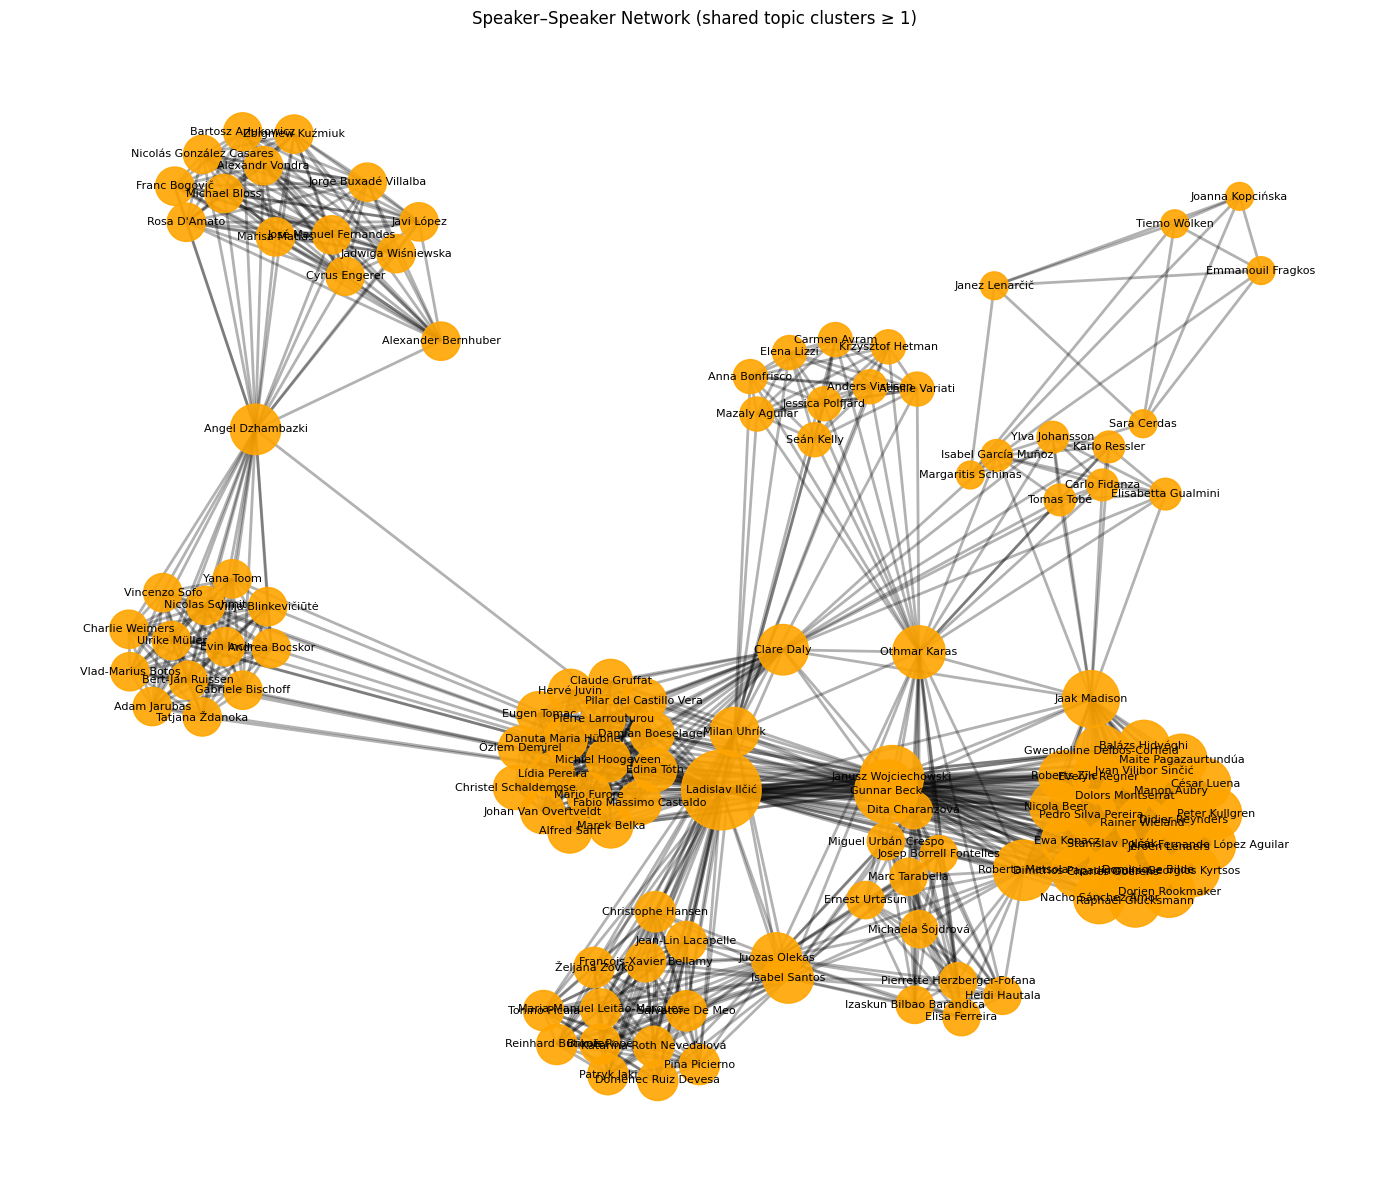

In [97]:
# 3) Visualize the filtered speaker–speaker network
if H.number_of_nodes() > 0:
    plt.figure(figsize=(14, 12))

    pos = nx.spring_layout(H, k=0.9, iterations=100, seed=42)

    # edge width = number of shared clusters
    weights = [H[u][v]["weight"] for u, v in H.edges()]
    max_w = max(weights) if weights else 1
    edge_widths = [0.5 + 3 * (w / max_w) for w in weights]

    nx.draw_networkx_edges(H, pos, width=edge_widths, alpha=0.3)

    # node size ~ degree
    deg = dict(H.degree())
    node_sizes = [200 + 40 * deg[n] for n in H.nodes()]

    nx.draw_networkx_nodes(
        H, pos,
        nodelist=list(H.nodes()),
        node_color="orange",
        node_size=node_sizes,
        alpha=0.9,
    )

    nx.draw_networkx_labels(H, pos, font_size=8)

    plt.title(f"Speaker–Speaker Network (shared topic clusters ≥ {MIN_SHARED_CLUSTERS})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No speaker–speaker edges meet the shared-cluster threshold.")


In [107]:
import networkx as nx
import pandas as pd

# ======================================
# Use your Speaker–Speaker graph
# ======================================
G = G_SS     # <-- change if needed


# ======================================
# 1. DEGREE CENTRALITY
# ======================================
deg_cent = nx.degree_centrality(G)

deg_df = pd.DataFrame([
    {"speaker": n, "degree_centrality": deg_cent[n]}
    for n in G.nodes()
]).sort_values("degree_centrality", ascending=False)


# ======================================
# 2. WEIGHTED DEGREE (strength)
# ======================================
weighted_degree = dict(G.degree(weight="weight"))

wdeg_df = pd.DataFrame([
    {"speaker": n, "weighted_degree": weighted_degree[n]}
    for n in G.nodes()
]).sort_values("weighted_degree", ascending=False)


# ======================================
# 3. BETWEENNESS CENTRALITY
# ======================================
bet_cent = nx.betweenness_centrality(G, normalized=True, weight="weight")

bet_df = pd.DataFrame([
    {"speaker": n, "betweenness": bet_cent[n]}
    for n in G.nodes()
]).sort_values("betweenness", ascending=False)


# ======================================
# 4. CLOSENESS CENTRALITY
# ======================================
clo_cent = nx.closeness_centrality(G, distance=None)

clo_df = pd.DataFrame([
    {"speaker": n, "closeness": clo_cent[n]}
    for n in G.nodes()
]).sort_values("closeness", ascending=False)


# ======================================
# 5. Print Results
# ======================================
print("\n=== TOP SPEAKERS BY DEGREE CENTRALITY ===")
print(deg_df.head(15))

print("\n=== TOP SPEAKERS BY WEIGHTED DEGREE (Strength) ===")
print(wdeg_df.head(15))

print("\n=== TOP SPEAKERS BY BETWEENNESS CENTRALITY ===")
print(bet_df.head(15))

print("\n=== TOP SPEAKERS BY CLOSENESS CENTRALITY ===")
print(clo_df.head(15))



=== TOP SPEAKERS BY DEGREE CENTRALITY ===
                  speaker  degree_centrality
2          Ladislav Ilčić           0.620968
5    Janusz Wojciechowski           0.379032
52            Gunnar Beck           0.379032
7         Roberta Metsola           0.338710
101          Jaak Madison           0.298387
10           Othmar Karas           0.250000
23        Balázs Hidvéghi           0.233871
14       Georgios Kyrtsos           0.233871
28        Didier Reynders           0.233871
44    Pedro Silva Pereira           0.233871
39            Nicola Beer           0.233871
34             Ewa Kopacz           0.233871
54        Dominique Bilde           0.233871
55       Dorien Rookmaker           0.233871
37         Rainer Wieland           0.233871

=== TOP SPEAKERS BY WEIGHTED DEGREE (Strength) ===
                  speaker  weighted_degree
2          Ladislav Ilčić               79
5    Janusz Wojciechowski               49
52            Gunnar Beck               49
7         Rob

#### across all four centrality measures — degree, strength, betweenness, and closeness — Ladislav Ilčić is consistently the most central and influential speaker in the network.

This means Ilčić is:
* the most connected (degree)
* the most active in shared-topic discussions (strength)
* the key bridge connecting different groups (betweenness)
* the most globally accessible in the speaker discourse space (closeness)

Other highly central speakers include:
* Janusz Wojciechowski
* Gunnar Beck
* Roberta Metsola
* Jaak Madison

These speakers collectively form the core of the European Parliament’s 2023–24 debate structure, acting either as generalists, hubs, or bridges.

## Building a knowledge graph for party -> speaker -> topic connection

Nodes: 144 Edges: 275


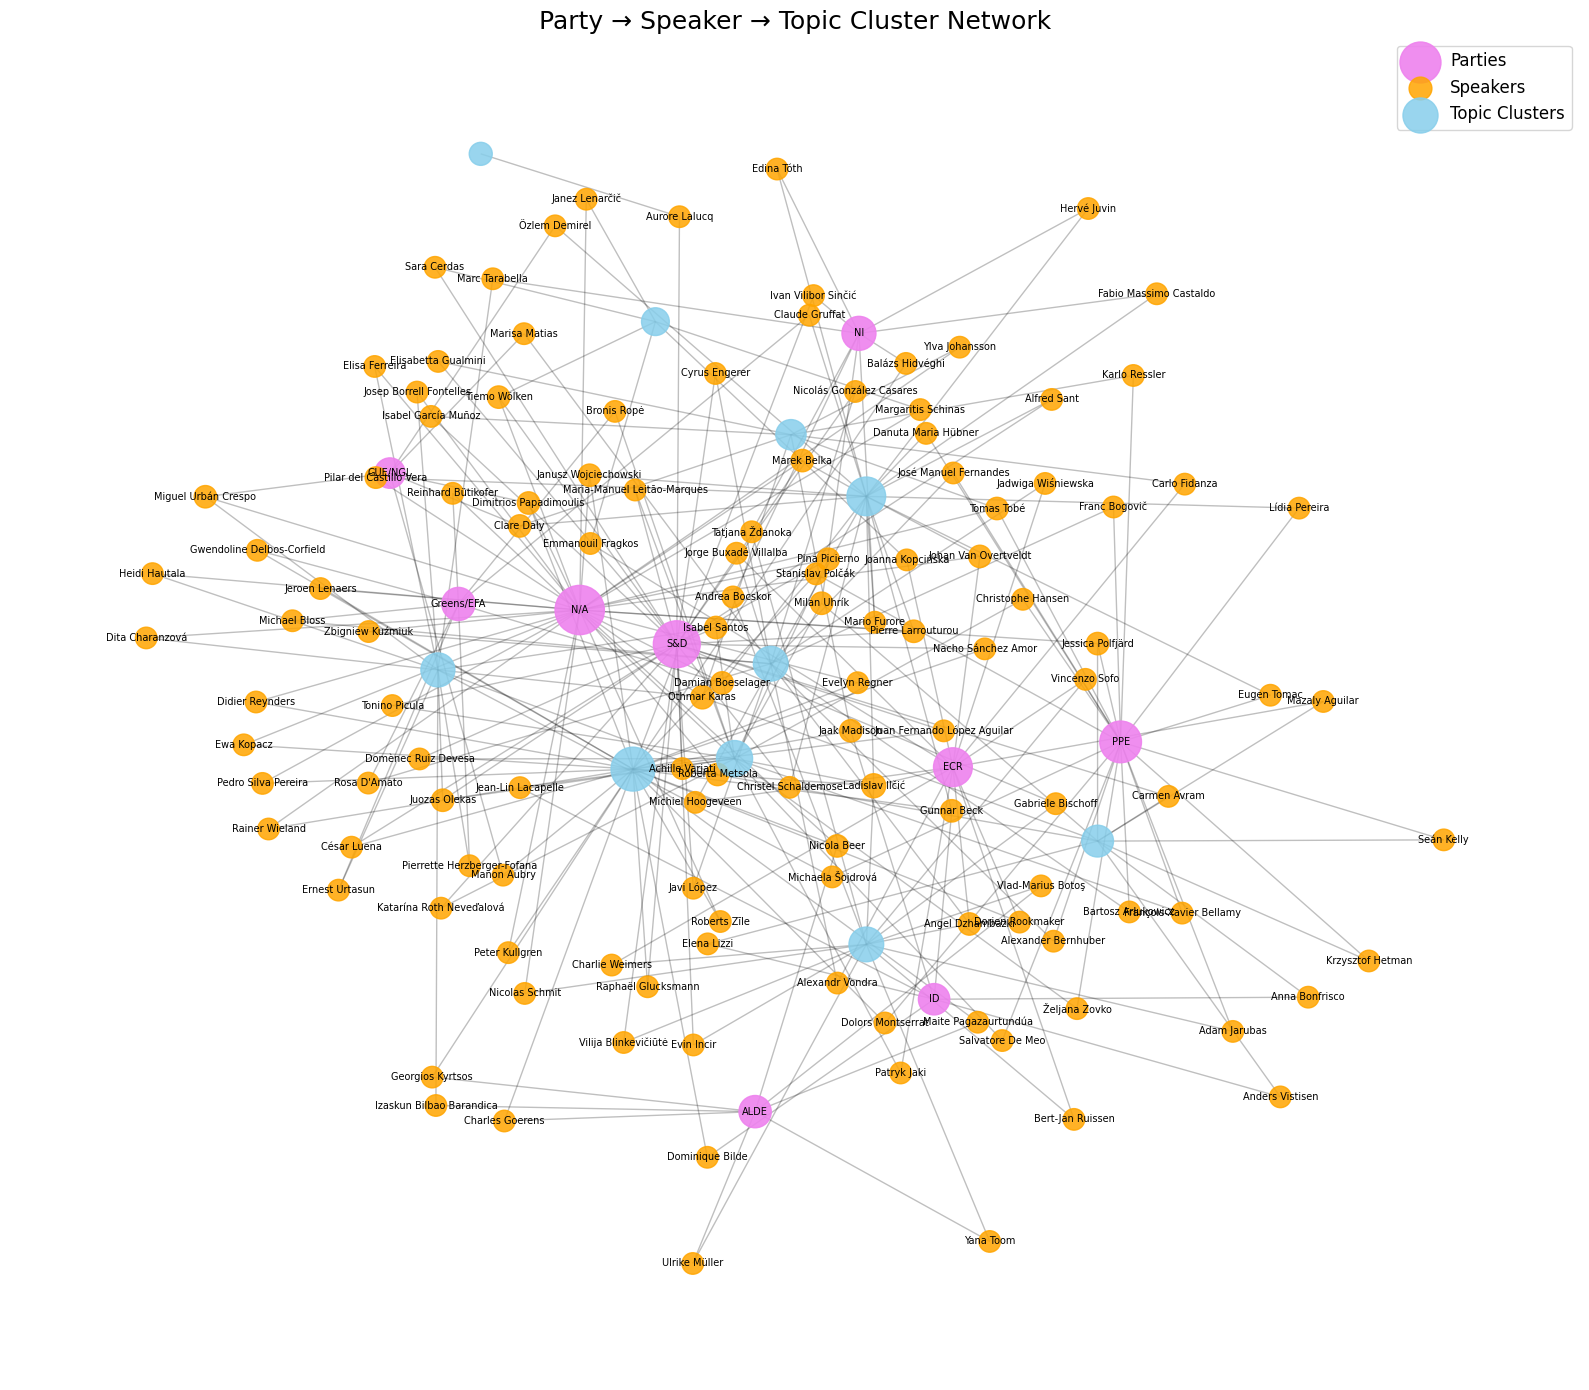

In [99]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1) Prepare the dataframe
df_psc = docs_df[["speaker_party", "speaker", "topic_cluster_label"]].copy()

# Clean columns
df_psc["speaker_party"] = df_psc["speaker_party"].astype(str).str.strip()
df_psc["speaker"] = df_psc["speaker"].astype(str).str.strip()
df_psc["topic_cluster_label"] = df_psc["topic_cluster_label"].astype(str).str.strip()

df_psc = df_psc[
    (df_psc["speaker_party"].notna()) &
    (df_psc["speaker_party"] != "") &
    (df_psc["speaker"].notna()) &
    (df_psc["speaker"] != "") &
    (df_psc["topic_cluster_label"].notna()) &
    (df_psc["topic_cluster_label"] != "")
].reset_index(drop=True)

# 2) Create graph
G_PSC = nx.Graph()

for _, row in df_psc.iterrows():
    party  = row["speaker_party"]
    speaker = row["speaker"]
    cluster = row["topic_cluster_label"]

    # Add nodes with roles
    G_PSC.add_node(party,   node_type="party")
    G_PSC.add_node(speaker, node_type="speaker")
    G_PSC.add_node(cluster, node_type="topic_cluster")

    # Add edges
    G_PSC.add_edge(party,   speaker, relation="belongs_to")
    G_PSC.add_edge(speaker, cluster, relation="mentions_cluster")

print("Nodes:", G_PSC.number_of_nodes(), "Edges:", G_PSC.number_of_edges())

# 3) Visualize with spring layout
plt.figure(figsize=(16, 14))

pos = nx.spring_layout(G_PSC, k=0.9, iterations=120, seed=42)

# Separate groups
party_nodes   = [n for n, d in G_PSC.nodes(data=True) if d["node_type"] == "party"]
speaker_nodes = [n for n, d in G_PSC.nodes(data=True) if d["node_type"] == "speaker"]
cluster_nodes = [n for n, d in G_PSC.nodes(data=True) if d["node_type"] == "topic_cluster"]

# Compute degrees for node sizing
deg = dict(G_PSC.degree())
party_sizes   = [300 + 30 * deg[n] for n in party_nodes]
speaker_sizes = [200 + 20 * deg[n] for n in speaker_nodes]
cluster_sizes = [250 + 25 * deg[n] for n in cluster_nodes]

# Draw edges
nx.draw_networkx_edges(G_PSC, pos, alpha=0.25)

# Draw nodes
nx.draw_networkx_nodes(G_PSC, pos,
    nodelist=party_nodes,
    node_color="violet",
    node_size=party_sizes,
    alpha=0.9,
    label="Parties"
)

nx.draw_networkx_nodes(G_PSC, pos,
    nodelist=speaker_nodes,
    node_color="orange",
    node_size=speaker_sizes,
    alpha=0.85,
    label="Speakers"
)

nx.draw_networkx_nodes(G_PSC, pos,
    nodelist=cluster_nodes,
    node_color="skyblue",
    node_size=cluster_sizes,
    alpha=0.85,
    label="Topic Clusters"
)

# Labels (only parties + speakers; clusters can stay optional)
labels = {}
for n in party_nodes + speaker_nodes:
    labels[n] = n

nx.draw_networkx_labels(G_PSC, pos, labels=labels, font_size=7)

plt.title("Party → Speaker → Topic Cluster Network", fontsize=18)
plt.axis("off")
plt.legend(scatterpoints=1, fontsize=12)
plt.tight_layout()
plt.show()


In [110]:
from pyvis.network import Network
import networkx as nx
import pandas as pd

# =========================================================
# 1) Build the 3-mode graph G_PSC if it doesn't exist yet
#    Nodes: party, speaker, topic_cluster_label
# =========================================================
if "G_PSC" not in globals():
    if "docs_df" not in globals():
        raise RuntimeError("docs_df is not defined. Make sure your dataframe is loaded first.")

    df_psc = docs_df[["speaker_party", "speaker", "topic_cluster_label"]].copy()

    df_psc["speaker_party"] = df_psc["speaker_party"].astype(str).str.strip()
    df_psc["speaker"] = df_psc["speaker"].astype(str).str.strip()
    df_psc["topic_cluster_label"] = df_psc["topic_cluster_label"].astype(str).str.strip()

    df_psc = df_psc[
        (df_psc["speaker_party"] != "") &
        (~df_psc["speaker_party"].isna()) &
        (df_psc["speaker"] != "") &
        (~df_psc["speaker"].isna()) &
        (df_psc["topic_cluster_label"] != "") &
        (~df_psc["topic_cluster_label"].isna())
    ].reset_index(drop=True)

    G_PSC = nx.Graph()
    for _, row in df_psc.iterrows():
        party   = row["speaker_party"]
        speaker = row["speaker"]
        cluster = row["topic_cluster_label"]

        G_PSC.add_node(party,   node_type="party")
        G_PSC.add_node(speaker, node_type="speaker")
        G_PSC.add_node(cluster, node_type="topic_cluster")

        G_PSC.add_edge(party,   speaker, relation="belongs_to")
        G_PSC.add_edge(speaker, cluster, relation="mentions_cluster")

    print("Built G_PSC:", G_PSC.number_of_nodes(), "nodes,", G_PSC.number_of_edges(), "edges")

# =========================================================
# 2) PyVis interactive visualization of G_PSC
# =========================================================

G = G_PSC   # <-- use your existing 3-mode graph

net = Network(
    height="750px",
    width="100%",
    bgcolor="#ffffff",
    font_color="black",
    notebook=True
)

net.barnes_hut()

# Styling for each node type
type_style = {
    "party":         {"color": "#c77dff", "size": 30},
    "speaker":       {"color": "#ff9f1c", "size": 18},
    "topic_cluster": {"color": "#2ec4b6", "size": 15},
}

# ---- Add nodes ----
for n, data in G.nodes(data=True):
    ntype = data.get("node_type", "other")
    style = type_style.get(ntype, {"color": "#999999", "size": 10})

    net.add_node(
        n,
        label=n,
        title=f"{ntype}: {n}",   # tooltip
        color=style["color"],
        size=style["size"],
        group=ntype,
    )

# ---- Add edges ----
for u, v, data in G.edges(data=True):
    rel = data.get("relation", "")
    w   = data.get("weight", 1)

    net.add_edge(
        u,
        v,
        title=rel,   # hover text on edge
        value=w      # influences thickness
    )

# ---- Physics / layout options ----
net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -6000,
      "centralGravity": 0.2,
      "springLength": 140,
      "springConstant": 0.05
    },
    "minVelocity": 0.75
  }
}
""")

# ---- Render to HTML ----
#uncomment the line below to save and view the interactive graph in a local HTML file
#net.show("party_speaker_topiccluster_interactive.html")


### Overall Summary

The Party → Speaker → Topic Cluster knowledge graph reveals how political communication flows inside the European Parliament. It shows which parties are most active, which speakers dominate the thematic landscape, and which high-level issues drive the majority of debates. It also highlights structural bridges between political camps and identifies central themes shaping the EU political agenda.

This network serves as a powerful analytical tool, transforming raw text into an interpretable map of political behaviour, institutional structure, and thematic influence.

# Limitations
1. High Number of Missing Topics (LLM Extraction Failure)
Out of 500 speeches, 335 (~67%) had no extracted topic:
primary_topic = None, topics = [].
This is a major limitation because it reduces the usable dataset for networks.
Causes: very short speeches, procedural comments (“Thank you, President”), or LLM confusion.

2. LLM Returned Inconsistent Topic Quality
Some topics were very good (e.g., “banking regulation”), but some were vague or too generic.
Some speeches on clear themes still got empty topics, showing model inconsistency.
Affects reliability of topic-based edges in the network.

3. Variation in Speech Length Caused Bias
Short interventions → often no topic extracted.
Long speeches → model extracts 2–3 topics.
This gives larger speeches more influence in the network.

4. Language Diversity Reduced LLM Accuracy
Speeches were in many languages (fr, it, es, hu, bg, pt, cs…).
Even though translated versions exist, the original-language text influenced extraction.
Non-English structures sometimes confused Gemini → more missing topics.

5. Translation Quality Variable
The translated text column exists but is inconsistent:
Some rows had no translated version.
A few included translation mismatches (you saw speeches repeating wrong pieces).
This affects how well LLM identifies a topic based on the English version.

6. Noisy or Procedural Speeches Mislead the Model
Many speeches are procedural, not substantive (e.g., opening remarks, votes, questions).
LLM cannot extract meaningful topics from such content → more missing topics.

7. Entity Normalization Problems
Speaker names and party names are not standardized:
Missing party in many rows
Speaker names sometimes repeated with accents or variations
This affects Party–Topic and Speaker–Speaker networks.

8. Reduced Dataset Size After Cleaning
After removing the 335 rows with no topics, the dataset shrank to 165 usable speeches.
Smaller dataset → fewer edges → weak or sparse networks.
This limits the strength of centrality analysis and community detection.

9. Topic Extraction Limited to 1–3 Topics per Speech
This artificial limit (needed for LLM consistency) may hide additional topics.
Some speeches discuss many issues, but the model only outputs 1–3.

10. LLM Topic Schema Too Simplistic
Single primary_topic cannot capture complex debates.
This over-simplifies reality and affects the richness of the networks you build.

11. Network Edges Depend Entirely on LLM Quality
Speaker–Topic edges exist only if LLM successfully extracted a topic.
If the LLM failed for a speech, the speaker vanishes from the network → structural distortion.

12. Loss of Temporal and Contextual Nuance
The 2023-only filter removes debates before/after major events, limiting dynamic analysis.
All speeches treated equally, even though debates differ in context (urgent, routine, etc.).



## Future Directions

* Extend analysis to multiple years to detect evolution of issue salience

* Apply community detection (Louvain) to identify political “clusters” of speakers

* Add sentiment or stance dimensions to edges

* Integrate formal roles (committee membership, leadership positions)

* Use embeddings instead of LLM clustering for stability and reproducibility